# Marine Energy Pipeline Analysis 1

I met with Chitra and her team (James, Max, J...) and discussed their intended integration with MHKDR. The context of this work product is that Chitra's group runs the ME pipeline on other data for other data repositories throughout the DOE portfolio. Chitra's group has yet to run the ME pipeline on MHKDR. Because of this, they want a short list of low-hanging fruit archival datasets that they can run through the ME pipeline, so that they can show value before the end of the fiscal year.

The aim of this notebook is to generate this list of low-hanging fruit 

### Setup

In [1]:
import primrea.core
from primrea import *
import re

mhkdr_api = 'https://mhkdr.openei.org/api?action=getSubmissionsForPRIMRE'
primre_data = primrea.core.primrea_data()

In [2]:
primre_data.tethys_dataframe.head(3)

,URI,type,landingPage,sourceURL,title,description,author,organization,originationDate,spatial,technologyType,tags,modifiedDate,signatureProject,attachment
0,https://tethys.pnnl.gov/node/499,"[Document, Document/Journal Article]",https://tethys.pnnl.gov/publications/marine-re...,https://www.mdpi.com/1996-1073/10/10/1512/htm,Marine Renewable Energy in the Mediterranean S...,"In this work, an extended overview of the mari...","[Soukissian, T., Denaxa, D., Karathanasi, F., ...","[Hellenic Centre for Marine Research (HCMR), N...",2017-09-29,[],[],"[Environment, Human Dimensions]",2024-01-22 09:24:45,[],[]
1,https://tethys.pnnl.gov/node/500,"[Document, Document/Report]",https://tethys.pnnl.gov/publications/port-fair...,http://bps.energy/projects,The Port Fairy Pilot Wave Energy Project Envir...,This Environmental Management Plan (EMP) detai...,[BioPower Systems],[BioPower Systems],2016-02-09,"{'coordinates': ['-38.398417000000', '142.1726...",[Wave],"[Environment, Environmental Impact Assessment]",2024-01-22 09:24:45,[],[https://tethys.pnnl.gov/sites/default/files/p...
2,https://tethys.pnnl.gov/node/501,"[Document, Document/Journal Article]",https://tethys.pnnl.gov/publications/baseline-...,https://www.sciencedirect.com/science/article/...,Baseline assessment of underwater noise in the...,The Ria Formosa is a sheltered large coastal l...,"[Soares, C., Pacheco, A., Zabel, F., González-...",[Marine Sensing and Acoustic Technologies (Mar...,2020-01-10,"{'coordinates': ['36.972554000000', '-7.870570...","[Current, Current/Tidal]","[Environment, Noise]",2024-01-22 09:24:45,[],[]


Rats! Yeah here is where I left off on the primrea development, and I am unable to use the (planned) core implementation of MHKDR because it would require additional effort on the structure.

Because of this, I will simply script using the functions in the primrea package, as the additional structure of primrea would not aid this use case anyway. In addition, figuring out the MHKDR integration is going to be a somewhat large lift, and think it prudent to put that off until dedicated primrea work is accepted.

In [3]:
#help(primrea.kh_table_gen.entry_based)
#help(primrea.core)

In [5]:
mhkdr_df = primrea.core.api_to_df(mhkdr_api)

In [6]:
# Creating a list of "entry ids" for the mhkdr_df dataframe
ids = list()
for i in range(0, len(mhkdr_df)):
    id = primrea.kh_table_gen.entry_based.find_entry_id(mhkdr_df['URI'][i])
    ids.append(id)

In [7]:
# Assigning the "entry ids" field
mhkdr_df['entry_id'] = ids
mhkdr_df.head(2)

,URI,type,landingPage,sourceURL,title,description,author,organization,originationDate,spatial,technologyType,tags,signatureProject,modifiedDate,entry_id
0,https://mhkdr.openei.org/submissions/548,"[Dataset, Document/Report]",https://mhkdr.openei.org/submissions/548,https://mhkdr.openei.org/submissions/548,"CalWave - xWave Device, Non-Commercially Sensi...",CalWave has developed a submerged pressure dif...,"[Marcus Lehmann, Ryan Davidson]",[CalWave Power Technologies Inc.],2024-02-29 07:00:00,"{'boundingCoordinatesNE': [44.63067800397145, ...",[Wave],"[MHK, Marine, Hydrokinetic, energy, power, wav...",[],2024-04-25 20:40:00,548
1,https://mhkdr.openei.org/submissions/547,"[Dataset, Document/Report, Dataset/Data]",https://mhkdr.openei.org/submissions/547,https://mhkdr.openei.org/submissions/547,CalWave - Reports and Plans for xWave Device D...,CalWave has developed a submerged pressure dif...,"[Thomas Boerner, Nigel Kojimoto, Marcus Lehman...",[CalWave Power Technologies Inc.],2024-02-29 07:00:00,"{'boundingCoordinatesNE': [44.69319166311689, ...",[Wave],"[MHK, Marine, Hydrokinetic, energy, power, Wav...",[],2024-04-25 20:48:08,547


In [8]:
mhkdr_tags_df = primrea.kh_table_gen.entry_based.construct_tags_table(mhkdr_df)
mhkdr_tags_df.head(3)

,entry_id,tag
0,548,MHK
1,548,Marine
2,548,Hydrokinetic


### Dev

Now that the proper tables are set up, we can begin to isolate the timeseries MHKDR entries, and return their urls.

In [9]:
len(set(mhkdr_tags_df['tag']))

2573

There are 2573 unique tags across MHKDR entries.

In [10]:
mhkdr_tags_unq = set(mhkdr_tags_df['tag'])

In [11]:
p = re.compile('time')

In [12]:
time_tags = list()
for i in mhkdr_tags_unq:
    re_result = p.search(i)
    if re_result != None:
        time_tags.append(i)
    #re_results.append(re_result)

In [13]:
time_tags

['timeseries', 'real-time', 'time series', 'Run time engine', 'time-domain']

It appears that "Run time engine" tag is probably a false positive. In this situation, particularly because of the casing, I presume that this is a one-off created by a content curator, that does not contain time-series data of interest to Chitra and her team. I will attempt to show it to demonstrate this.

The other four tags, however, seem to be pertinent, interesting to Chitra, and I will therefore include them all in the list of target datasets.

#### Isolate MHKDR Entr(y/ies) having the tag 'Run time engine'

In [14]:
mhkdr_tags_df.head(3)

,entry_id,tag
0,548,MHK
1,548,Marine
2,548,Hydrokinetic


In [15]:
sus_tag_df = mhkdr_tags_df[mhkdr_tags_df['tag']=='Run time engine']
sus_tag_df

,entry_id,tag
10480,64,Run time engine
10506,63,Run time engine


In [16]:
mhkdr_df.merge(sus_tag_df, how='inner')

,URI,type,landingPage,sourceURL,title,description,author,organization,originationDate,spatial,technologyType,tags,signatureProject,modifiedDate,entry_id,tag
0,https://mhkdr.openei.org/submissions/64,"[Dataset, Document/Report, Dataset/Archive]",https://mhkdr.openei.org/submissions/64,https://mhkdr.openei.org/submissions/64,MOIS LabVIEW Software,Software developed in LabVIEW for the Modular ...,[Eric Nelson],[National Renewable Energy Laboratory],2015-12-03 07:00:00,"{'boundingCoordinatesNE': [69.409022910825, -5...",[],"[MHK, Marine, Hydrokinetic, energy, power, Lab...",[],2020-07-30 17:57:55,64,Run time engine
1,https://mhkdr.openei.org/submissions/63,"[Dataset, Dataset/Archive]",https://mhkdr.openei.org/submissions/63,https://mhkdr.openei.org/submissions/63,MOIS CAD Models,SolidWorks models of the Modular Ocean Instrum...,[Eric Nelson],[National Renewable Energy Laboratory],2015-12-03 07:00:00,"{'boundingCoordinatesNE': [72.814209083213, -5...",[],"[MHK, Marine, Hydrokinetic, energy, power, CAD...",[],2020-07-30 18:00:03,63,Run time engine


Viewing the two submissions:

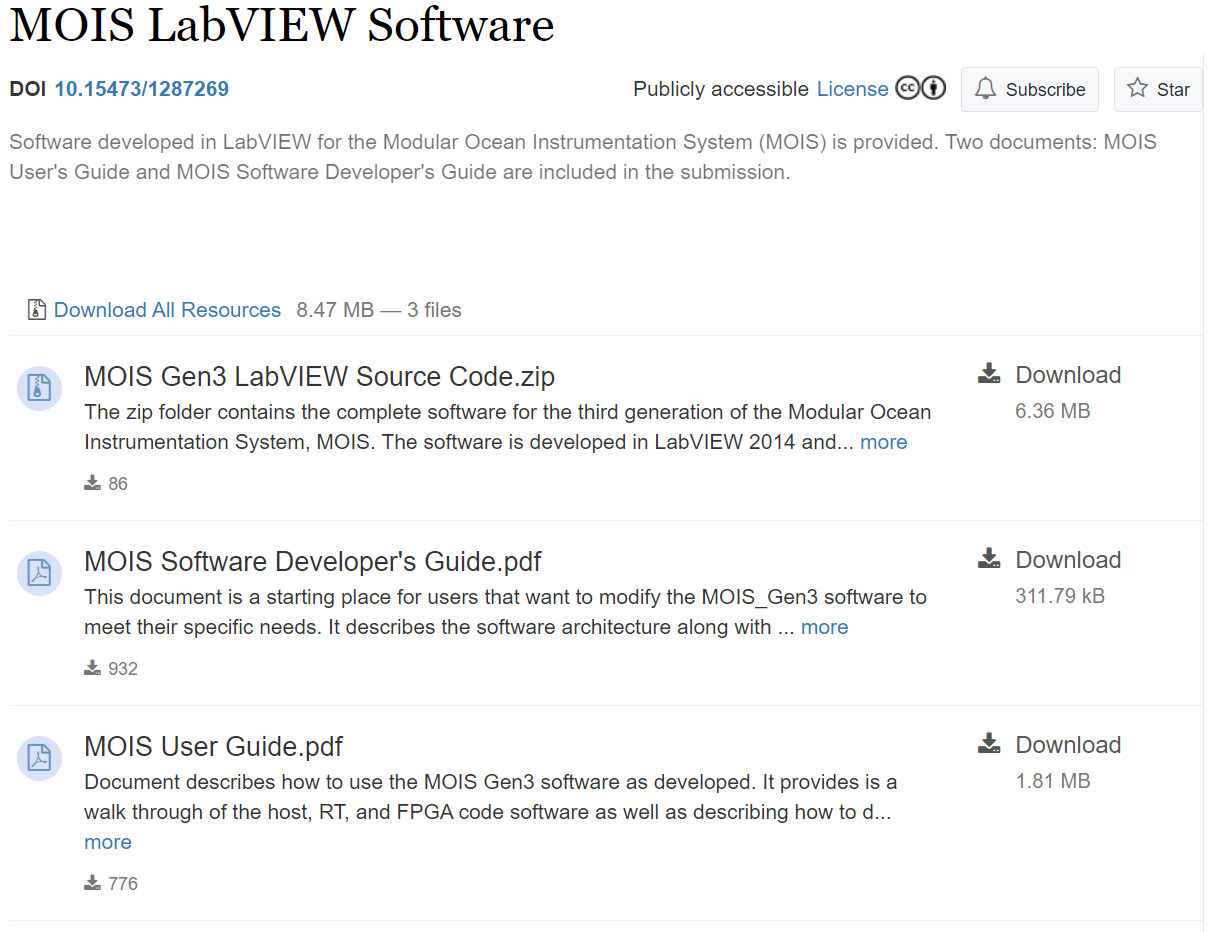
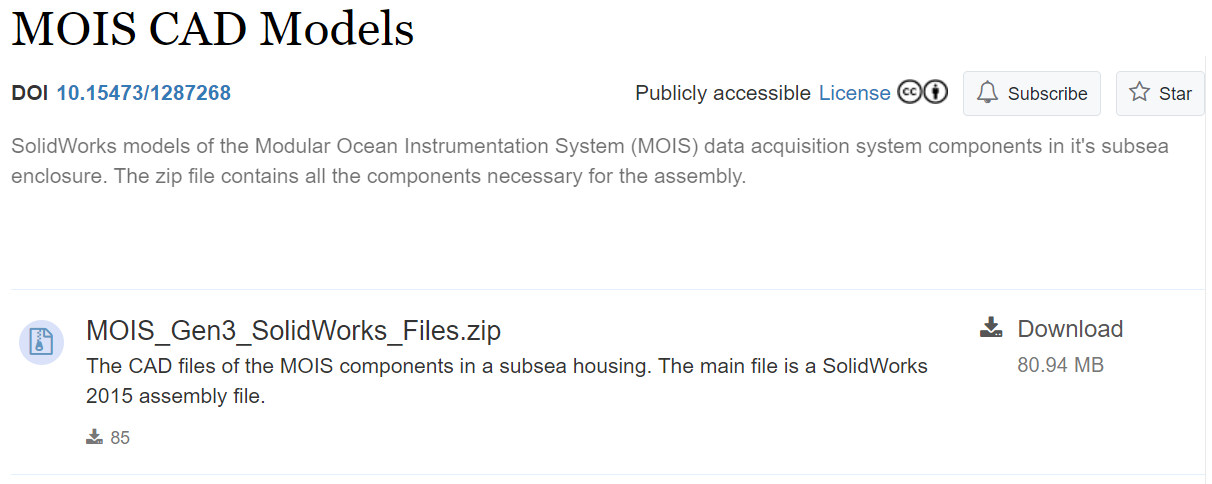

We can see that these are models and software files, and therefore do not contain data of interest to the ME pipeline team.

#### Isolating the entries containing the other four tags:
 - 'real-time'
 - 'time series'
 - 'timeseries'
 - 'time-domain'

In [17]:
mhkdr_tags_df_time = mhkdr_tags_df[(mhkdr_tags_df['tag']=='real-time') | (mhkdr_tags_df['tag']=='time series') | (mhkdr_tags_df['tag']=='timeseries') | (mhkdr_tags_df['tag']=='time-domain')]
mhkdr_tags_df_time

,entry_id,tag
2082,393,timeseries
3289,331,time-domain
5542,235,real-time
5559,232,time series
6018,218,time-domain
8256,149,time-domain
10667,54,time series


In [18]:
mhkdr_df_interest = mhkdr_df.merge(mhkdr_tags_df_time, how='inner')

In [19]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('colheader_justify', 'center')

In [24]:
df_final = mhkdr_df_interest[['URI', 'title', 'tag']]
df_final = df_final.rename(columns={'URI': 'URL', 'title': 'Title', 'tag': 'Tag'})
df_final = df_final.sort_values('Tag', ascending=False)
df_final

,URL,Title,Tag
0,https://mhkdr.openei.org/submissions/393,Timeseries Data from the Experimental Testing of the OPI's Prototype Hydraulic Drivetrain.,timeseries
1,https://mhkdr.openei.org/submissions/331,Performance estimation of resonance-enhanced dual-buoy wave energy converter using coupled time-domain simulation,time-domain
4,https://mhkdr.openei.org/submissions/218,AeroDyn V15.04: Design Tool for Wind and MHK Turbines,time-domain
5,https://mhkdr.openei.org/submissions/149,Modeling and Performance Data for Heaving Buoy Wave Energy Converter with a Compressible Degree of Freedom (CDOF),time-domain
3,https://mhkdr.openei.org/submissions/232,USWAN Model Hindcast East Coast Regional Model (ECoRM),time series
6,https://mhkdr.openei.org/submissions/54,University of Massachusetts Marine Renewable Energy Center Waverider Buoy Data,time series
2,https://mhkdr.openei.org/submissions/235,"Next Generation RivGen Power System: Kvichak River, AK Overwinter Ice Study",real-time


In [25]:
df_final = df_final.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df_final.set_properties(**{'text-align': 'left'}).hide_index()

C:\Users\deca761\AppData\Local\Temp\ipykernel_14676\3705500776.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df_final.set_properties(**{'text-align': 'left'}).hide_index()


URL,Title,Tag
https://mhkdr.openei.org/submissions/393,Timeseries Data from the Experimental Testing of the OPI's Prototype Hydraulic Drivetrain.,timeseries
https://mhkdr.openei.org/submissions/331,Performance estimation of resonance-enhanced dual-buoy wave energy converter using coupled time-domain simulation,time-domain
https://mhkdr.openei.org/submissions/218,AeroDyn V15.04: Design Tool for Wind and MHK Turbines,time-domain
https://mhkdr.openei.org/submissions/149,Modeling and Performance Data for Heaving Buoy Wave Energy Converter with a Compressible Degree of Freedom (CDOF),time-domain
https://mhkdr.openei.org/submissions/232,USWAN Model Hindcast East Coast Regional Model (ECoRM),time series
https://mhkdr.openei.org/submissions/54,University of Massachusetts Marine Renewable Energy Center Waverider Buoy Data,time series
https://mhkdr.openei.org/submissions/235,"Next Generation RivGen Power System: Kvichak River, AK Overwinter Ice Study",real-time
